<a href="https://colab.research.google.com/github/dajebbar/FreeCodeCamp-python-data-analysis/blob/main/simpleImputeModifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
import os

od.version()
url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(url)


data_dir = 'weather-dataset-rattle-package'

os.listdir(data_dir)
train_csv = data_dir + '/weatherAUS.csv'

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
raw_df = pd.read_csv(train_csv)

categorical_column = ['Location','WindGustDir', 'WindDir9am', 
                      'WindDir3pm',  'RainToday']
numerical_column = ['MinTemp', 'MaxTemp', 'Sunshine', 'WindSpeed9am', 
                    'Pressure3pm', 'Temp9am', 'Temp3pm', 'Cloud3pm' ]

target_column = 'RainTomorrow'
year = pd.to_datetime(raw_df.Date).dt.year
date = 'Date'

df = raw_df[categorical_column + numerical_column + [target_column]]
df.head()

,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,MinTemp,MaxTemp,Sunshine,WindSpeed9am,Pressure3pm,Temp9am,Temp3pm,Cloud3pm,RainTomorrow
0,Albury,W,W,WNW,No,13.4,22.9,NaN,20.0,1007.1,16.9,21.8,NaN,No
1,Albury,WNW,NNW,WSW,No,7.4,25.1,NaN,4.0,1007.8,17.2,24.3,NaN,No
2,Albury,WSW,W,WSW,No,12.9,25.7,NaN,19.0,1008.7,21.0,23.2,2.0,No
3,Albury,NE,SE,E,No,9.2,28.0,NaN,11.0,1012.8,18.1,26.5,NaN,No
4,Albury,W,ENE,NW,No,17.5,32.3,NaN,7.0,1006.0,17.8,29.7,8.0,No


In [5]:
df[numerical_column].isna().sum()

MinTemp          1485
MaxTemp          1261
Sunshine        69835
WindSpeed9am     1767
Pressure3pm     15028
Temp9am          1767
Temp3pm          3609
Cloud3pm        59358
dtype: int64

In [6]:
df[categorical_column].isna().sum()

Location           0
WindGustDir    10326
WindDir9am     10566
WindDir3pm      4228
RainToday       3261
dtype: int64

In [7]:
df[target_column].isna().any()

True

In [8]:
df2 = df.copy()

In [9]:
df2.dropna(subset=[target_column, 'RainToday'], inplace=True)

In [10]:
df2[target_column].isna().sum()

0

In [11]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
# impute the original dataframe
imputer.fit(df2[numerical_column])

SimpleImputer()

In [12]:
X_train = df2[year < 2015]
X_test = df2[year >= 2015]
y_train = df2[year < 2015][target_column]
y_test = df2[year >= 2015][target_column]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((97988, 14), (42799, 14), (97988,), (42799,))

In [13]:
X_train[numerical_column] = imputer.transform(X_train[numerical_column])
X_test[numerical_column] = imputer.transform(X_test[numerical_column])

In [14]:
X_train[numerical_column].isna().sum()

MinTemp         0
MaxTemp         0
Sunshine        0
WindSpeed9am    0
Pressure3pm     0
Temp9am         0
Temp3pm         0
Cloud3pm        0
dtype: int64

In [15]:
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
)
from sklearn.compose import ColumnTransformer

num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

processor = ColumnTransformer([
                                 ('one-hot', 
                                  cat_transformer, 
                                  categorical_column),
                                 ('min-max-scaler', 
                                  num_transformer, 
                                  numerical_column)
])

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline([
                  ('processor', processor),
                  ('classifier', LogisticRegression(max_iter=300, solver='liblinear'))

])

model.fit(X_train, y_train)

Pipeline(steps=[('processor',
                 ColumnTransformer(transformers=[('one-hot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Location', 'WindGustDir',
                                                   'WindDir9am', 'WindDir3pm',
                                                   'RainToday']),
                                                 ('min-max-scaler',
                                                  MinMaxScaler(),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Sunshine', 'WindSpeed9am',
                                                   'Pressure3pm', 'Temp9am',
                                                   'Temp3pm', 'Cloud3pm'])])),
                ('classifier',
                 LogisticRegression(max_iter=

In [17]:
preds = model.predict(X_train)

In [18]:
preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [19]:
probs = model.predict_proba(X_train)
probs

array([[0.70669889, 0.29330111],
       [0.90973445, 0.09026555],
       [0.87735455, 0.12264545],
       ...,
       [0.9654857 , 0.0345143 ],
       [0.96546126, 0.03453874],
       [0.93574271, 0.06425729]])

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, preds)

0.8314283381638568

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, preds, normalize='true')

array([[0.9442709 , 0.0557291 ],
       [0.56298743, 0.43701257]])

In [23]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 83.14%


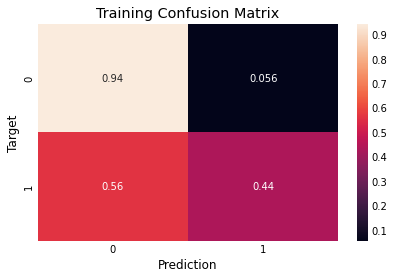

In [24]:
train_preds = predict_and_plot(X_train, y_train, 'Training')

Accuracy: 82.18%


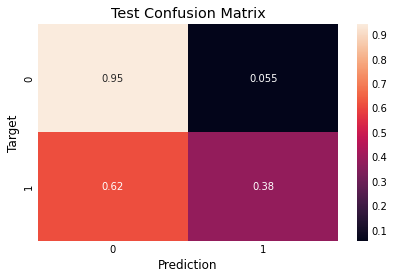

In [25]:
test_preds = predict_and_plot(X_test, y_test, 'Test')